In [1]:
from os import path

import numpy as np
import matplotlib.pyplot as plt
import urllib3
from urllib.request import HTTPError
import pandas as pd

from datetime import datetime, timedelta
from astropy.time import Time
from matplotlib import dates, cm
from matplotlib.ticker import MultipleLocator
import json
from astropy.io import fits

import sunpy.timeseries
from sunpy.net import Fido
from sunpy.net import attrs as a

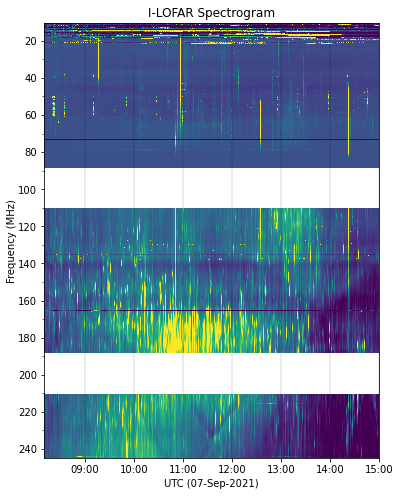

In [12]:
def plot(bstfile, saveloc):
    """
    Plots the spectrum along side a catalog of the radio bursts and goes data
    Parameters
    ----------
    bstfile : .dat file
        The I-LOFAR bst .dat file.
    Returns
    -------
    Plot of the spectrum along side a catalog of the radio bursts
    """
    
    if saveloc[-1] != '/':
        saveloc = saveloc + '/'



    def gridmaker(obs_start, t_arr):
        
        bargrid=[]
        
        temptime = datetime(year  = int(datetime.strftime(obs_start, '%Y')),
                            month = int(datetime.strftime(obs_start, '%m')),
                            day   = int(datetime.strftime(obs_start, '%d')),
                            hour  = int(datetime.strftime(obs_start, '%H')))
        while temptime < obs_start + timedelta(seconds=len(t_arr)):
            bargrid.append(temptime)
            temptime=temptime+timedelta(hours=1)
            
        for hour in bargrid:
            plt.axvline(hour, c='black', alpha=0.1)
        del temptime
    
    def start(bstfile, subbands=np.arange(488)):
        def sb_to_freq(sb=np.arange(488)):
            def sb_to_freq_math(x): return ((n-1)+(x/512))*(clock/2)
            clock = 200 #MHz
            sb_3 = np.arange(54,454,2)
            sb_5 = np.arange(54,454,2)
            sb_7 = np.arange(54,290,2)
            n = 1
            freq_3 = sb_to_freq_math(sb_3)
            n = 2
            freq_5 = sb_to_freq_math(sb_5)
            n = 3
            freq_7 = sb_to_freq_math(sb_7)
            freq = np.concatenate((freq_3,freq_5,freq_7),axis=0)
            freq = freq[sb[0]:sb[-1]+1]
            return freq   
    
        data = np.fromfile(bstfile)
        
        t_len = (data.shape[0]/len(subbands))
        data = data.reshape(-1,len(subbands))
        
        obs_start = bstfile[len(bstfile)-27:len(bstfile)-12]
        
        obs_start = datetime.strptime(obs_start,"%Y%m%d_%H%M%S")

        date_format = dates.DateFormatter("%H:%M")
        obs_len = timedelta(seconds = t_len)
        obs_end = obs_start + obs_len
        t_lims = [obs_start, obs_end]
        t_lims = dates.date2num(t_lims)
        
        
        t_arr = np.arange(0,data.shape[0])
        t_arr = t_arr*timedelta(seconds=1)
        t_arr = obs_start+t_arr
        t_arr = dates.date2num(t_arr)

        data_F = data/np.mean(data[:100],axis=0)
        sbs = subbands

        freqs = sb_to_freq(sbs)
        
        return obs_start, date_format, t_arr, data_F, freqs
    
    def spectrogram(data, y, x, date_format, bstfile, vdata=None, tfs=True, colorbar=False, cmap='viridis', alpha=None, figsize=None, flip=True):
        
        if vdata is None:
            vdata = data
        g1 = 200
        g2 = 400
            
        if figsize is None:
            pass
        else:
            fig, ax = plt.subplots(figsize=figsize, dpi=400)
        
        v1 , v2 = 5 , 98
        
        plt.pcolormesh(x,y[:g1],data.T[:g1], shading='auto',
                       vmin=np.percentile(vdata,v1), vmax=np.percentile(vdata,v2),cmap=cmap,alpha=alpha);
        if tfs == True:
            plt.pcolormesh(x,y[g1:g2],data.T[g1:g2], shading='auto',
                           vmin=np.percentile(vdata,v1), vmax=np.percentile(vdata,v2),cmap=cmap,alpha=alpha);
            plt.pcolormesh(x,y[g2:],data.T[g2:], shading='auto',
                           vmin=np.percentile(vdata,v1), vmax=np.percentile(vdata,v2),cmap=cmap,alpha=alpha);
        
        if flip == True:
            plt.gca().invert_yaxis()
            
        plt.gca().xaxis_date()
        plt.gca().xaxis.set_major_formatter(date_format)
        plt.gca().yaxis.set_major_locator(MultipleLocator(20))
        plt.gca().yaxis.set_minor_locator(MultipleLocator(10))
        
        plt.xlabel("UTC "+datetime.strftime(dates.num2date(x[0]), '(%d-%b-%Y)'))
        plt.ylabel("Frequency (MHz)")

        
        if colorbar == True:
            plt.colorbar()
            
        
        plt.xlim(x[0], x[-1])

    obs_start, date_format, t_arr, data_F, freqs = start(bstfile)
    bstfile = bstfile[-27:]
    
    y, m, d = datetime.strftime(obs_start, '%Y'), datetime.strftime(obs_start, '%m'), datetime.strftime(obs_start, '%d')
    

    My_FIGURE = plt.figure(figsize=(6.,8.))
    ax =plt.subplot2grid((1, 1), (0, 0))
    spectrogram(data_F,freqs,t_arr, date_format, bstfile)
    gridmaker(obs_start, t_arr)
    plt.title("I-LOFAR Spectrogram")
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xlim([datetime(2021, 9, 7, 8, 10, 0), datetime(2021, 9, 7, 15, 0, 0)])
    ax.get_yaxis().set_label_coords(-0.08,0.5)
    My_FIGURE.savefig('/Users/thomas/SS Research Project/' + "/i-lofar_plot.png")
    return freqs



x = plot('20210907_080752_bst_00X.dat', '/Users/thomas/Desktop/STIX/STIX-Compare')